In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
from copy import deepcopy
import datetime

In [3]:
from joblib import dump as jdump
from joblib import load as jload

In [4]:
import torch


print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, TensorDataset

In [6]:
cwd = os.getcwd()
print(cwd)
# cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/opt/data/chemprop_run/git/notebooks/AltModels
/opt/data/chemprop_run/git


In [7]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelper import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [8]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

5

### Preparing dataset 

In [12]:
score = 'total_thresh'
score_val = 4

In [13]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

# v_1: GNN
# v_2: Alt Models (Baseline)
data_fname = 'data_v2'

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
# print(targetdata_dir)

path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr


In [15]:
xFlat = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X_flat.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))
expression = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [16]:
xFlatMat = torch.stack([torch.cat(i) for i in list(xFlat.values())])
xFlatMat.shape

torch.Size([25757, 18])

In [17]:
x = torch.cat([xFlatMat, torch.tensor(expression)], dim=1)
x.shape

torch.Size([25757, 926])

In [18]:
y

array([0, 0, 0, ..., 0, 1, 1])

In [19]:
fold_partitions = get_stratified_partitions(y,
                                            num_folds=5,
                                            valid_set_portion=0.1,
                                            random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.5764356969533567
class: 1 norm count: 0.4235643030466433
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5763929334109882
class: 1 norm count: 0.4236070665890118

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.576

In [20]:
print("Number of training graphs: "+ str(len(fold_partitions[0]['train'])))
print("Number of validation graphs: "+ str(len(fold_partitions[0]['validation'])))
print("Number of testing graphs: "+ str(len(fold_partitions[0]['test'])))


Number of training graphs: 18544
Number of validation graphs: 2061
Number of testing graphs: 5152


### Alt Models

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
# from sklearn.inspection import permutation_importance

In [22]:
x_np = x.numpy()
y_np = y

In [23]:
scaler = StandardScaler()
x_np_scale = scaler.fit_transform(x_np)

In [24]:
targetdata_dir_exp

'/opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2/experiments'

In [25]:
model_name = "Default"

In [26]:
# model = LogisticRegression(max_iter=10000,
#                                       random_state=42,
#                                       solver="lbfgs",
#                                       penalty='l2',
#                                       l1_ratio=None,
#                                       verbose=1)

In [27]:
# model = DecisionTreeClassifier()

In [28]:
# model = KNeighborsClassifier()

In [29]:
# model = DecisionTreeClassifier()

In [30]:
model = GradientBoostingClassifier()
model_name = "GradBoost"

In [31]:
time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Start: " + time_stamp)

q_i = 0

# for q_i in range(len(fold_partitions)):
partition = fold_partitions[q_i]

ids_train = partition['train']
ids_test = partition['test']

part_train_x = np.take(x_np_scale, ids_train, axis=0)
part_train_y = np.take(y_np, ids_train, axis=0)

part_test_x = np.take(x_np_scale, ids_test, axis=0)
part_test_y = np.take(y_np, ids_test, axis=0)

# exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
# create_directory(os.path.join(exp_dir, "predictions"))
# create_directory(os.path.join(exp_dir, "modelStates"))

# model_fit = model.fit(part_train_x, part_train_y)

# prob_scores_arr = model_fit.predict_proba(part_test_x)
# pred_class = model_fit.predict(part_test_x)
# ref_class = part_test_y
# epoch = 0
# dsettype = 'test'

# dset_perf = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
#                           outlog = os.path.join(exp_dir, dsettype + ".log"))

# predictions_df = build_predictions_df(ids_test, ref_class, pred_class, prob_scores_arr)
# predictions_df.to_csv(os.path.join(exp_dir, 'predictions', f'epoch_{epoch}_predictions_{dsettype}.csv'))

# jdump(model_fit, os.path.join(exp_dir, 'modelStates', f'{model_name}_modelFit.joblib')) 
    
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

Start: 2022-07-05_09-55-44
End: 2022-07-05_09-55-44


In [32]:
# time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# print("Start: " + time_stamp)

# for q_i in range(len(fold_partitions)):
#     partition = fold_partitions[q_i]
    
#     ids_train = partition['train']
#     ids_test = partition['test']
    
#     part_train_x = np.take(x_np_scale, ids_train, axis=0)
#     part_train_y = np.take(y_np, ids_train, axis=0)
    
#     part_test_x = np.take(x_np_scale, ids_test, axis=0)
#     part_test_y = np.take(y_np, ids_test, axis=0)
    
#     exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
#     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(exp_dir, "modelStates"))
    
#     model_fit = model.fit(part_train_x, part_train_y)
    
#     prob_scores_arr = model_fit.predict_proba(part_test_x)
#     pred_class = model_fit.predict(part_test_x)
#     ref_class = part_test_y
#     epoch = 0
#     dsettype = 'test'

#     dset_perf = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
#                               outlog = os.path.join(exp_dir, dsettype + ".log"))
    
#     predictions_df = build_predictions_df(ids_test, ref_class, pred_class, prob_scores_arr)
#     predictions_df.to_csv(os.path.join(exp_dir, 'predictions', f'epoch_{epoch}_predictions_{dsettype}.csv'))
    
#     jdump(model_fit, os.path.join(exp_dir, 'modelStates', f'{model_name}_modelFit.joblib')) 
    
# print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

### SHAP values

In [33]:
import shap

In [34]:
# source: https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L52

atomic_features = ['AtomicNum', 'ChiralTag', 'TotalDegree', 
                   'FormalCharge', 'TotalNumHs', 'NumRadicalElectrons',
                   'Hybridization', 'IsAromatic', 'IsInRing']

In [66]:
nr_drug_feat = len(atomic_features)*2

In [35]:
def list_prefix(l, pre):
    return [pre+i for i in l]

In [36]:
gene_gex = pd.read_csv('../../data/preprocessing/gene_gex.tsv', sep='\t')
all_feat = list_prefix(atomic_features, "Drug1_")+list_prefix(atomic_features, "Drug2_")+list(gene_gex.GENE_SYMBOLS)
len(all_feat)

926

In [37]:
all_feat

['Drug1_AtomicNum',
 'Drug1_ChiralTag',
 'Drug1_TotalDegree',
 'Drug1_FormalCharge',
 'Drug1_TotalNumHs',
 'Drug1_NumRadicalElectrons',
 'Drug1_Hybridization',
 'Drug1_IsAromatic',
 'Drug1_IsInRing',
 'Drug2_AtomicNum',
 'Drug2_ChiralTag',
 'Drug2_TotalDegree',
 'Drug2_FormalCharge',
 'Drug2_TotalNumHs',
 'Drug2_NumRadicalElectrons',
 'Drug2_Hybridization',
 'Drug2_IsAromatic',
 'Drug2_IsInRing',
 'TSPAN6',
 'SCYL3',
 'BAD',
 'LAP3',
 'SNX11',
 'CASP10',
 'CFLAR',
 'FKBP4',
 'RBM6',
 'SLC25A13',
 'ST7',
 'CIAPIN1',
 'MYCBP2',
 'RALA',
 'ETV1',
 'TBXA2R',
 'PAF1',
 'ELAC2',
 'PAFAH1B1',
 'KIAA0100',
 'TRAPPC6A',
 'E2F2',
 'SYPL1',
 'CYB561',
 'UBE3C',
 'NCAPD2',
 'NISCH',
 'BTK',
 'FYN',
 'AKAP8L',
 'BRCA1',
 'UBR7',
 'MVP',
 'HEBP1',
 'MAMLD1',
 'CAPN1',
 'BID',
 'NUDCD3',
 'ATP2C1',
 'ZDHHC6',
 'RNH1',
 'ALAS1',
 'DERA',
 'TOMM34',
 'FAS',
 'CD44',
 'TBPL1',
 'GRN',
 'TIMP2',
 'RAI14',
 'PNKP',
 'EPHA3',
 'DSG2',
 'RFC2',
 'MAPK9',
 'HERPUD1',
 'RRP12',
 'AKR7A2',
 'LAMA3',
 'TRAPPC3'

In [38]:
time_stamp = "2022-07-04_12-27-15" # "2022-06-20_18-27-11" # "2022-06-29_15-59-39" #

import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

1

In [39]:
for edir in exp_dirs:
    fold = int(edir.split("/")[-1].split('_')[1])
    print(fold)

0


In [40]:
# # time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# # print("Start: " + time_stamp)

# for edir in exp_dirs:
#     fold = edir.split("/")[-1].split('_')[1]
#     q_i = int(fold)
#     print("fold:", fold)
# # for q_i in range(len(fold_partitions)):
#     partition = fold_partitions[q_i]
    
#     ids_train = partition['train']
#     ids_test = partition['test']
    
#     part_train_x = np.take(x_np_scale, ids_train, axis=0)
#     part_train_y = np.take(y_np, ids_train, axis=0)
    
#     part_test_x = np.take(x_np_scale, ids_test, axis=0)
#     part_test_y = np.take(y_np, ids_test, axis=0)
    
# #     exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
# #     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(edir, "Shap"))
    
#     model_fit = jload(os.path.join(edir, 'modelStates', f'{model_name}_modelFit.joblib')) 
# #     model_fit = model.fit(part_train_x, part_train_y)
    
#     explainer = shap.Explainer(model_fit.predict, part_test_x)
#     # Calculates the SHAP values - It takes some time
#     shap_values = explainer(part_test_x, max_evals=2000)
    
#     jdump(shap_values, os.path.join(edir, 'Shap', f'{model_name}_shapValues.joblib')) 
    
# print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

In [41]:
# # Fits the explainer
# explainer = shap.Explainer(model_fit.predict, part_test_x)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(part_test_x, max_evals=2000)

In [42]:
# ReaderWriter.dump_data(shap_values, os.path.join(exp_dir, f'shap_values.pkl'))

In [43]:
model_fit = jload(os.path.join(edir, 'modelStates', f'{model_name}_modelFit.joblib')) 

shap_values = jload(os.path.join(edir, 'Shap', f'{model_name}_shapValues.joblib')) 

In [44]:
# shap_values = ReaderWriter.read_data(os.path.join(exp_dirs[0], f'shap_values.pkl'))
shap_values

.values =
array([[ 0.055,  0.   ,  0.07 , ...,  0.   ,  0.   ,  0.   ],
       [ 0.01 ,  0.   ,  0.13 , ...,  0.   ,  0.   ,  0.   ],
       [-0.02 ,  0.   , -0.045, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.03 ,  0.005,  0.135, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.005, ...,  0.   ,  0.   ,  0.   ],
       [ 0.01 ,  0.005,  0.015, ...,  0.   ,  0.   ,  0.   ]])

.base_values =
array([0.33, 0.33, 0.33, ..., 0.33, 0.33, 0.33])

.data =
array([[-0.17084287, -0.15152021,  0.77687611, ..., -0.40845414,
         0.85813763,  0.89785037],
       [-0.2449715 , -0.15152021,  0.59276845, ...,  0.0704298 ,
         0.56510498, -0.51746101],
       [-0.2282867 , -0.15152021, -0.72883753, ...,  0.0704298 ,
         0.56510498, -0.51746101],
       ...,
       [-0.31833381, -0.15152021,  1.17222452, ..., -0.99148492,
         0.70802992, -0.47901196],
       [-0.0884473 , -0.15152021, -0.04125095, ..., -0.45184989,
         1.07328074, -1.27451317],
       [-0.22763496

In [45]:
# sv = np.array(shap_values)

In [46]:
part_test_x.shape

(5152, 926)

In [47]:
y_part_test_x = model_fit.predict(part_test_x).astype("bool")
y_part_test_x.shape

(5152,)

In [48]:
pd.Series(y_part_test_x).value_counts()

False    3329
True     1823
dtype: int64

In [49]:
# shap values for survival
# sv_ones = sv[:,y,:]
# shap values for dying
# sv_zeros = sv[:,~y,:]

In [50]:
sv_ones = shap_values[y_part_test_x]
sv_zeros = shap_values[~y_part_test_x]

In [51]:
shap_values.values.shape

(5152, 926)

In [52]:
sv_ones.values.shape

(1823, 926)

In [53]:
sv_zeros.values.shape

(3329, 926)

In [ ]:
# shap.summary_plot(concat_folds_min_ones_delta_thresh[:, nr_drug_feat:],
#                   test_features_TP_ones_delta_thresh[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)

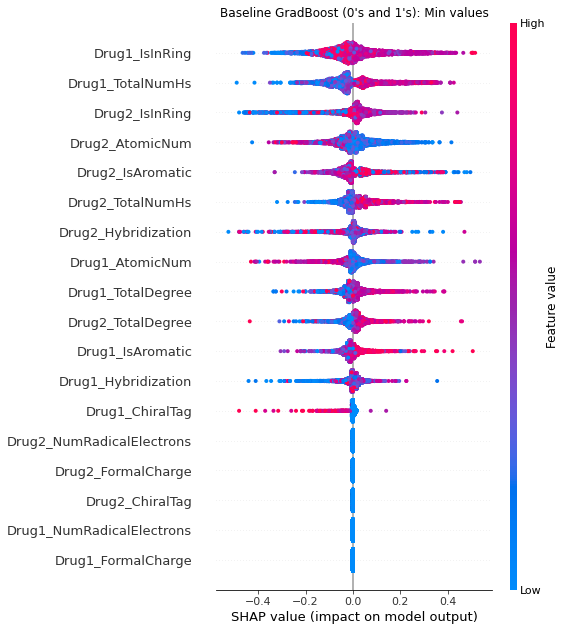

In [68]:
shap.summary_plot(shap_values[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  show=False)
plt.title(f"Baseline {model_name} (0's and 1's): Min values")
# plt.xlabel("Attribution")
plt.show()

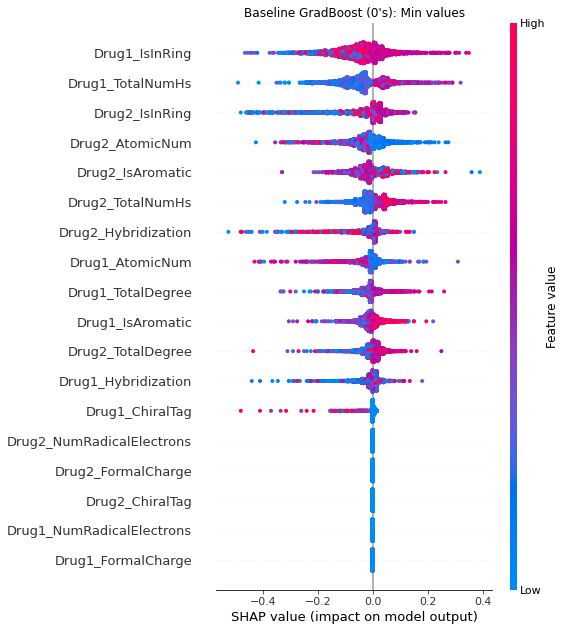

In [69]:
shap.summary_plot(sv_zeros[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  show=False)
# shap.summary_plot(sv_zeros, feature_names=all_feat, show=False)
plt.title(f"Baseline {model_name} (0's): Min values")
# plt.xlabel("Attribution")
plt.show()

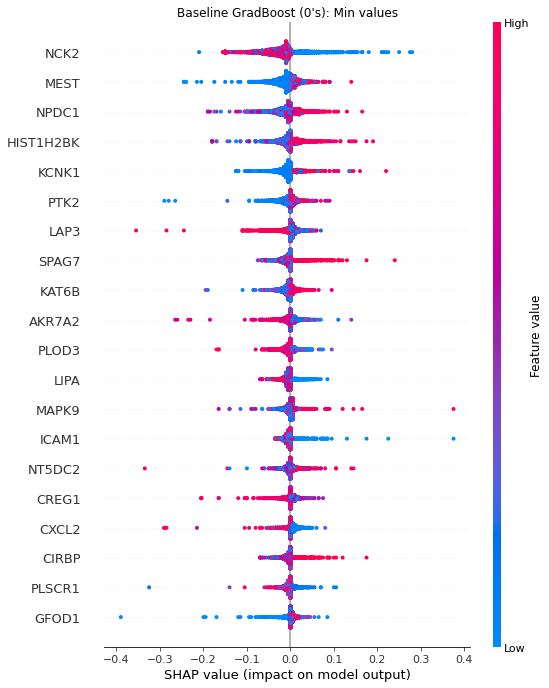

In [70]:
shap.summary_plot(sv_zeros[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  show=False)
# shap.summary_plot(sv_zeros, feature_names=all_feat, show=False)
plt.title(f"Baseline {model_name} (0's): Min values")
# plt.xlabel("Attribution")
plt.show()

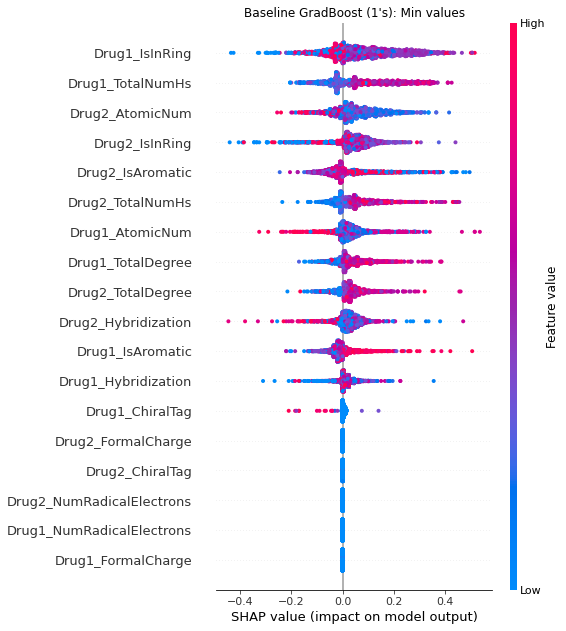

In [71]:
shap.summary_plot(sv_ones[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  show=False)
# shap.summary_plot(sv_ones, feature_names=all_feat, show=False)
plt.title(f"Baseline {model_name} (1's): Min values")
# plt.xlabel("Attribution")
plt.show()

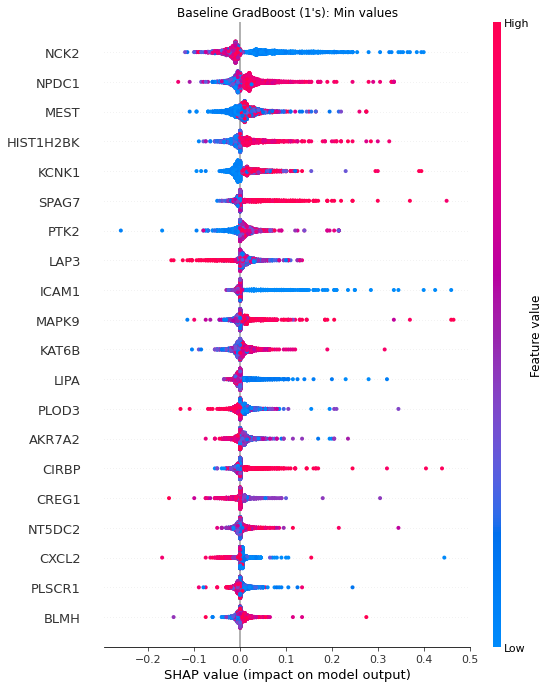

In [72]:
shap.summary_plot(sv_ones[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  show=False)
# shap.summary_plot(sv_ones, feature_names=all_feat, show=False)
plt.title(f"Baseline {model_name} (1's): Min values")
# plt.xlabel("Attribution")
plt.show()

In [57]:
# shap.bar_plot(shap_values, feature_names=all_feat)

In [58]:
# shap.plots.bar(shap_values, feature_names=all_feat)


In [59]:
# shap.plots.beeswarm(shap_values)


In [60]:
# shap.plots.heatmap(shap_values)


### Scores

In [ ]:
time_stamp = "2022-06-29_15-59-39" #"2022-06-20_18-27-11"

import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

In [ ]:
folds = []

for edir in exp_dirs:
    fold = edir.split("/")[-1].split('_')[1]
    with open(os.path.join(edir, "test.log")) as f:
        lines = f.read().splitlines()
        folds.append([fold, float(lines[18]), float(lines[22])])

In [ ]:
df_folds = pd.DataFrame(data=folds, columns=["Fold","AUPR", "AUC"]).set_index("Fold")
# df_folds["Fscore"] = df_folds.apply(lambda x: (2*x[0]*x[1])/(x[0]+x[1]), axis=1) # harmonic mean of AUC, AUPR
df_folds

In [ ]:
df_folds.mean(axis=0).values

In [ ]:
F_score(*df_folds.mean(axis=0).values)